9/19-9/24

This is code for the Kaggle Ames, Iowa Housing Prices Competition. I've already made submissions to this competition before, my lowest test error being 0.2 (putting me around 3800th place out of >4000 people). For my first retry with this dataset, I wanted to see how feature engineering along with intentional feature pruning (through my own observations, rather than PCA or using the correlation coefficient) would perform with a basic linear regression model.

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, learning_curve, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import locale
from scipy.stats import randint
locale.setlocale( locale.LC_ALL, '' )

'English_United States.1252'

In [3]:
train_set = pd.read_csv("train.csv")
test_set = pd.read_csv("test.csv")
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

[]

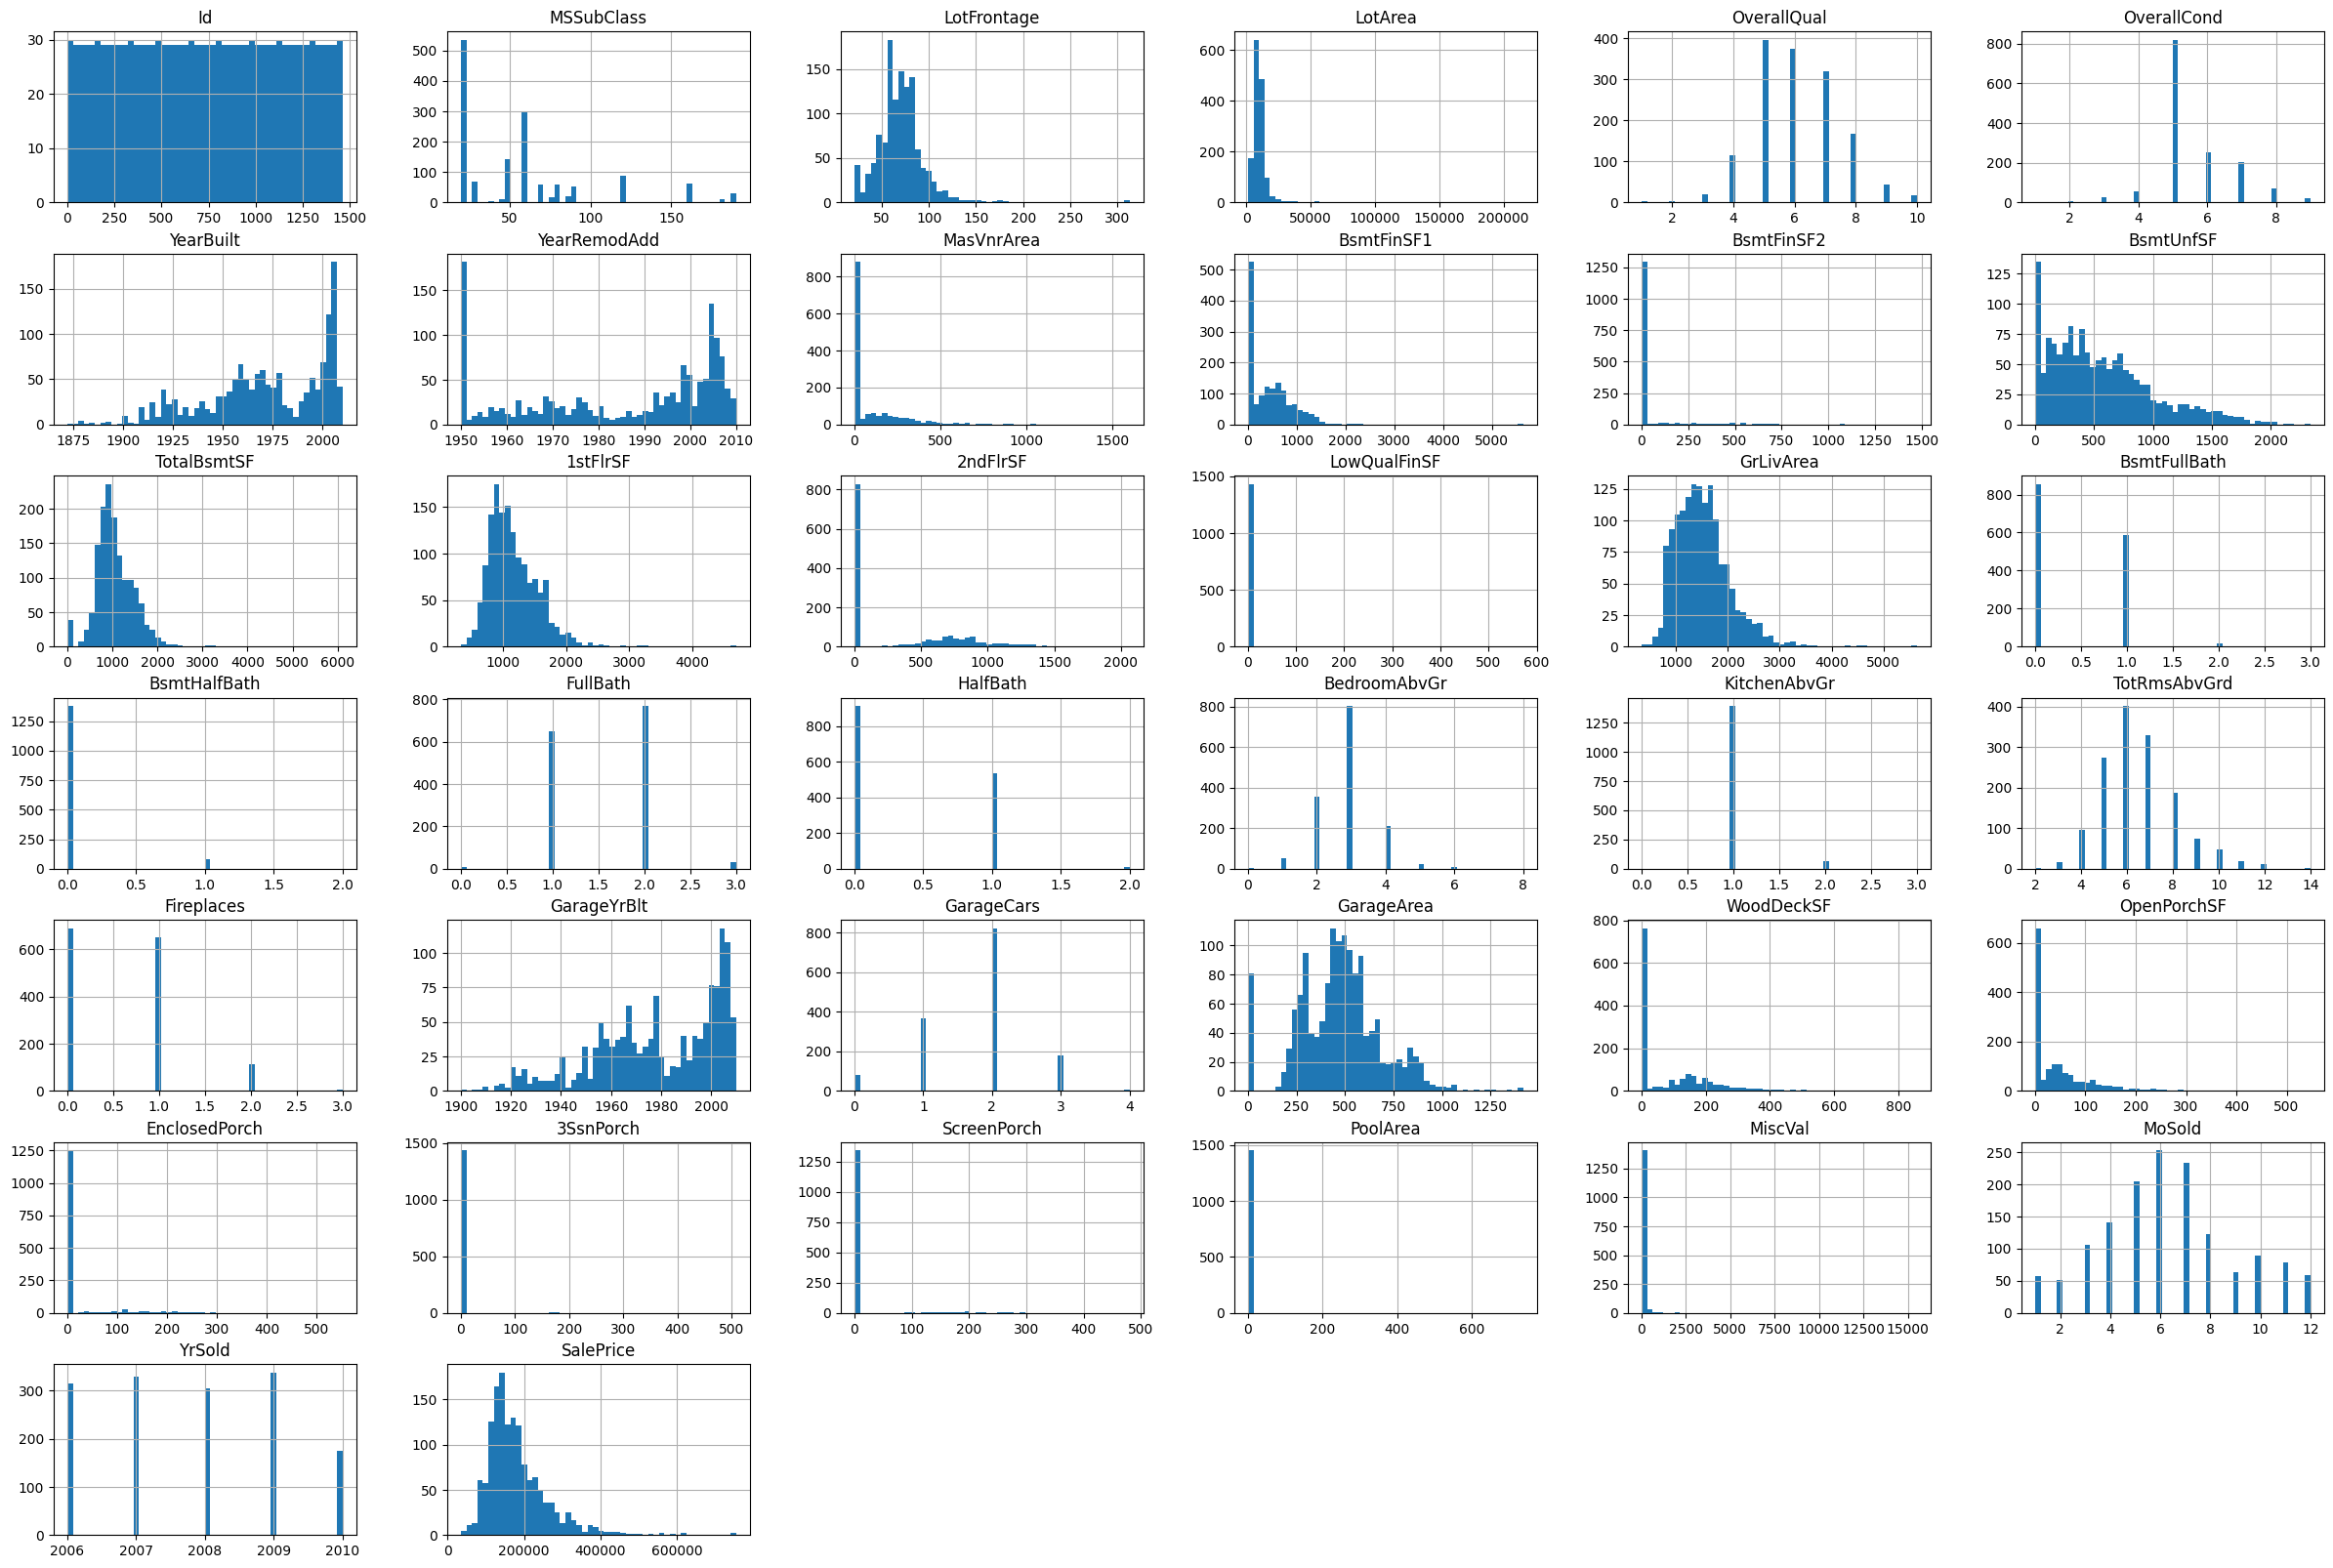

In [4]:
nec_num = train_set.select_dtypes(include=[np.number])
nec_num.hist(bins=50, figsize=(30, 20))
plt.tight_layout
plt.plot()

In [5]:
prices = pd.DataFrame(train_set["SalePrice"].copy())
nec_data = train_set.drop("SalePrice", axis=1) # labels
ids = test_set["Id"].copy()

In [6]:
# dropping features with too many null values
nec_data = nec_data.drop("Alley", axis=1)
nec_data = nec_data.drop("PoolQC", axis=1) 
nec_data = nec_data.drop("Fence", axis=1)  
nec_data = nec_data.drop("MiscFeature", axis=1)
nec_data = nec_data.drop("Id", axis=1) # too individual

# making new features
nec_data["has_porch"] = (nec_data["OpenPorchSF"] + nec_data["EnclosedPorch"] + nec_data["3SsnPorch"] + nec_data["ScreenPorch"] > 0)
nec_data["has_deck"] = (nec_data["WoodDeckSF"] > 0)
nec_data["has_pool"] = (nec_data["PoolArea"] > 0)
nec_data["TotalSF"] = nec_data["1stFlrSF"] + nec_data["2ndFlrSF"] + nec_data["TotalBsmtSF"]

# dropping more features
# considered irrelevant from feature description
nec_data = nec_data.drop("MiscVal", axis=1) 
nec_data = nec_data.drop("RoofStyle", axis=1) 
nec_data = nec_data.drop("RoofMatl", axis=1) 
nec_data = nec_data.drop("MasVnrType", axis=1) 
nec_data = nec_data.drop("MasVnrArea", axis=1) 
nec_data = nec_data.drop("BsmtFinSF1", axis=1) 
nec_data = nec_data.drop("BsmtFinType2", axis=1) 
nec_data = nec_data.drop("BsmtFinSF2", axis=1) 
nec_data = nec_data.drop("BsmtExposure", axis=1) 
nec_data = nec_data.drop("Heating", axis=1) # may not be irrelevant
nec_data = nec_data.drop("Electrical", axis=1) 
nec_data = nec_data.drop("Fireplaces", axis=1) 
nec_data = nec_data.drop("FireplaceQu", axis=1) 
nec_data = nec_data.drop("GarageYrBlt", axis=1) 
nec_data = nec_data.drop("GarageType", axis=1) 
nec_data = nec_data.drop("GarageFinish", axis=1) 
nec_data = nec_data.drop("MoSold", axis=1) 
nec_data = nec_data.drop("SaleType", axis=1) 
nec_data = nec_data.drop("SaleCondition", axis=1)

# considered irrelevant from histograms (too many 0 values)
nec_data = nec_data.drop("MSZoning", axis=1) 
nec_data = nec_data.drop("YrSold", axis=1) 
nec_data = nec_data.drop("LowQualFinSF", axis=1)

# considered possibly redundant
nec_data = nec_data.drop("YearRemodAdd", axis=1) 
nec_data = nec_data.drop("Condition2", axis=1) 
nec_data = nec_data.drop("Exterior2nd", axis=1) 
nec_data = nec_data.drop("BsmtUnfSF", axis=1) 

# used in self-made feature
nec_data = nec_data.drop("1stFlrSF", axis=1) 
nec_data = nec_data.drop("2ndFlrSF", axis=1) 
nec_data = nec_data.drop("TotalBsmtSF", axis=1) 
nec_data = nec_data.drop("GrLivArea", axis=1) 

nec_data = nec_data.drop("WoodDeckSF", axis=1) 

nec_data = nec_data.drop("PoolArea", axis=1) 

nec_data = nec_data.drop("OpenPorchSF", axis=1) 
nec_data = nec_data.drop("EnclosedPorch", axis=1) 
nec_data = nec_data.drop("3SsnPorch", axis=1) 
nec_data = nec_data.drop("ScreenPorch", axis=1) 

In [7]:
nec_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 43 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSSubClass    1460 non-null   int64  
 1   LotFrontage   1201 non-null   float64
 2   LotArea       1460 non-null   int64  
 3   Street        1460 non-null   object 
 4   LotShape      1460 non-null   object 
 5   LandContour   1460 non-null   object 
 6   Utilities     1460 non-null   object 
 7   LotConfig     1460 non-null   object 
 8   LandSlope     1460 non-null   object 
 9   Neighborhood  1460 non-null   object 
 10  Condition1    1460 non-null   object 
 11  BldgType      1460 non-null   object 
 12  HouseStyle    1460 non-null   object 
 13  OverallQual   1460 non-null   int64  
 14  OverallCond   1460 non-null   int64  
 15  YearBuilt     1460 non-null   int64  
 16  Exterior1st   1460 non-null   object 
 17  ExterQual     1460 non-null   object 
 18  ExterCond     1460 non-null 

In [8]:
# grouping objects that need ordinal encoding or one-hot encoding
ordinal_features = ["LotShape", "LandSlope", "HeatingQC", "Functional", "BsmtFinType1"]
col_name_list = nec_data.columns.values.tolist()
for name in col_name_list:
    if name[-4:] == "Qual" or name[-4:] == "Cond":
        ordinal_features.append(name)
one_hot_features = np.setdiff1d(list(nec_data.select_dtypes(include=['object']).columns), ordinal_features)

In [9]:
print(ordinal_features)
print()
print(one_hot_features)

['LotShape', 'LandSlope', 'HeatingQC', 'Functional', 'BsmtFinType1', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'KitchenQual', 'GarageQual', 'GarageCond']

['BldgType' 'CentralAir' 'Condition1' 'Exterior1st' 'Foundation'
 'HouseStyle' 'LandContour' 'LotConfig' 'Neighborhood' 'PavedDrive'
 'Street' 'Utilities']


[]

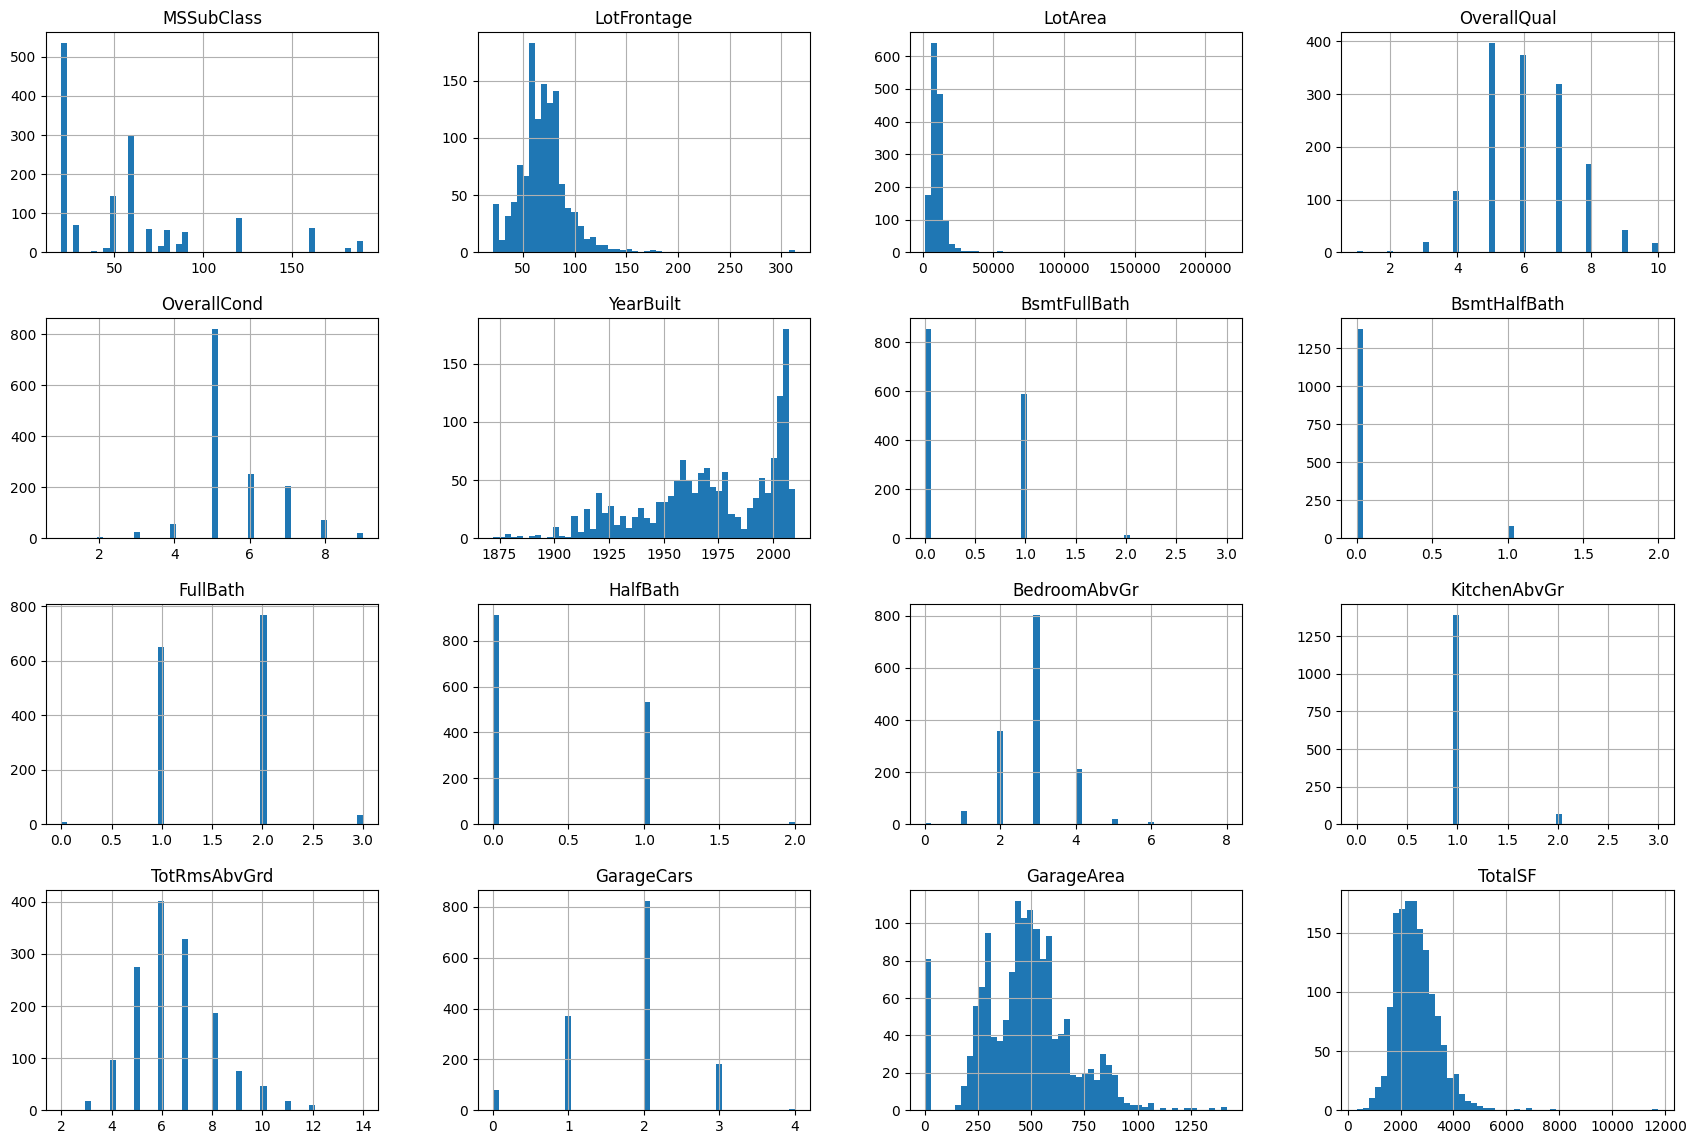

In [10]:
nec_num = nec_data.select_dtypes(include=[np.number])
nec_num.hist(bins=50, figsize=(21, 14))
plt.tight_layout
plt.plot()

In [11]:
log_features = ["MSSubClass", "LotFrontage", "LotArea", "YearBuilt", "TotalSF"]

In [12]:
def safe_log(x):
    return np.log(x + 1e-10)
     
#thanks to ChatGPT 3.5 for this function
log_transformer = FunctionTransformer(func=safe_log, inverse_func=np.exp)

num_tail_pipeline = make_pipeline(SimpleImputer(strategy="median"), log_transformer, StandardScaler())
category_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore"))
ranking_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OrdinalEncoder(), log_transformer)
num_norm_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

preprocess = ColumnTransformer([
    ("tail", num_tail_pipeline, log_features),
    ("category", category_pipeline, one_hot_features),
    ("ranking", ranking_pipeline, ordinal_features)],
    remainder=num_norm_pipeline
)

In [14]:
lin_reg = Pipeline([("pre", preprocess), ("reg", LinearRegression())])
lin_reg.fit(nec_data, prices)

housing_predictions = lin_reg.predict(nec_data)
for k in range(10):
    print(f"Real value: {locale.currency(prices.iloc[k].values[0], grouping=True)}, Prediction: {locale.currency(housing_predictions[k][0].round(2), grouping=True)}")

Real value: $208,500.00, Prediction: $215,339.17
Real value: $181,500.00, Prediction: $193,227.33
Real value: $223,500.00, Prediction: $211,660.99
Real value: $140,000.00, Prediction: $192,548.75
Real value: $250,000.00, Prediction: $311,106.11
Real value: $143,000.00, Prediction: $168,226.52
Real value: $307,000.00, Prediction: $282,602.14
Real value: $200,000.00, Prediction: $203,124.33
Real value: $129,900.00, Prediction: $153,249.27
Real value: $118,000.00, Prediction: $116,155.06


In [15]:
lin_rmse = mean_squared_error(prices, housing_predictions, squared=False)
print(lin_rmse)

29591.79120992887


In [16]:
rmse = -cross_val_score(lin_reg, nec_data, prices, scoring="neg_root_mean_squared_error", cv=10)
print(np.average(rmse))

c:\Users\user_02\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\user_02\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "c:\Users\user_02\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\Users\user_02\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "c:\Users\user_02\anaconda3\lib\site-packages\sklearn\utils\_response.py", line 109, in _get_response_values
    y_pred, pos_label = estimator.predict(X), None
  File "c:\Users\user_02\anaconda3\lib\site-packages\sklearn\pipeline.py", line 507, in predict
    Xt = transform.transform(Xt)
  File "c:\Users\user_02\anacon

nan


In [17]:
# test_set["has_porch"] = (test_set["OpenPorchSF"] + test_set["EnclosedPorch"] + test_set["3SsnPorch"] + test_set["ScreenPorch"] > 0)
# test_set["has_deck"] = (test_set["WoodDeckSF"] > 0)
# test_set["has_pool"] = (test_set["PoolArea"] > 0)
# test_set["TotalSF"] = test_set["1stFlrSF"] + test_set["2ndFlrSF"] + test_set["TotalBsmtSF"]
# test_pred = lin_reg.predict(test_set)
# with open('sacreddeer_house_new_submission_1.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerow(["Id", "SalePrice"])
#     for k in range(len(ids)):
#         writer.writerow([ids[k], test_pred[k][0]])

The test error of this model was 0.5, more than double the error of my best attempt at this competition previously. When I added a standard scaler to the ordinally-encoded features, the test error rose to 0.6. 

As one last step, I tried switching from using an ordinal encoder for some traits to a one-hot encoder for all traits. This is because the ordinal encoding was preventing me from analyzing validation error (for some unknown reason).

In [18]:
preprocess = ColumnTransformer([
    ("tail", num_tail_pipeline, log_features),
    ("category", category_pipeline, make_column_selector(dtype_include=object))],
    remainder=num_norm_pipeline
)
lin_reg = Pipeline([("pre", preprocess), ("reg", LinearRegression())])
lin_reg.fit(nec_data, prices)

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('tail',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function safe_log at 0x00000166586F2320>,
                                                                                       inverse_func=<ufun...
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'YearBuilt',
                                                   'TotalSF']),
                                                 ('category',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000166585D2B60>)])),
                ('reg', LinearRegression())])

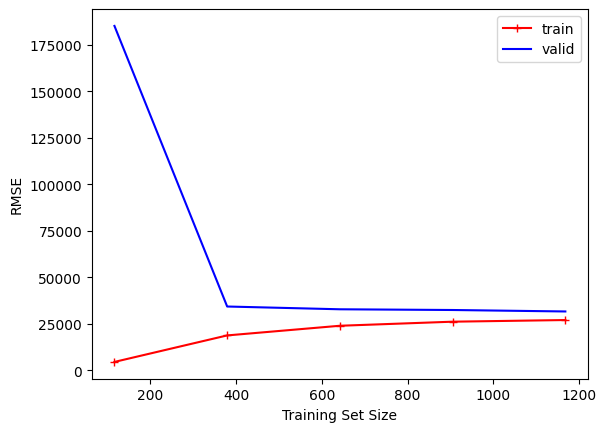

In [19]:
train_sizes, train_scores, valid_scores = learning_curve(
    lin_reg, nec_data, prices, scoring="neg_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, np.sqrt(train_errors), "r-+", label="train")
plt.plot(train_sizes, np.sqrt(valid_errors), "b-", label="valid")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend()

In [20]:
# test_set["has_porch"] = (test_set["OpenPorchSF"] + test_set["EnclosedPorch"] + test_set["3SsnPorch"] + test_set["ScreenPorch"] > 0)
# test_set["has_deck"] = (test_set["WoodDeckSF"] > 0)
# test_set["has_pool"] = (test_set["PoolArea"] > 0)
# test_set["TotalSF"] = test_set["1stFlrSF"] + test_set["2ndFlrSF"] + test_set["TotalBsmtSF"]
# test_pred = lin_reg.predict(test_set)
# with open('sacreddeer_house_new_submission_3.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerow(["Id", "SalePrice"])
#     for k in range(len(ids)):
#         writer.writerow([ids[k], test_pred[k][0]])

Unfortunately, the test error is still 0.6 with this change. One last test I want to do: random forests.

In [23]:
rdf_clf = Pipeline([("pre", preprocess), ("clf", RandomForestClassifier(random_state=446))])
rdf_clf.fit(nec_data, prices)

randdepth = np.array([3, 4, 5, 6, 7, 8, 9])
param_distribs = {"clf__max_depth": randdepth,
                  "clf__min_samples_leaf": randint(low=1, high=10),
                  "clf__n_estimators": randint(low=200, high=230)}
rmd_search = RandomizedSearchCV(
    rdf_clf, param_distributions=param_distribs, 
    n_iter=20, cv=5, scoring="neg_root_mean_squared_error", random_state=446
)
rmd_search.fit(nec_data, prices)
final_rnd_model = rmd_search.best_estimator_
print(final_rnd_model.get_params)

final_rnd_model.fit(nec_data, prices)
rmse2 = -cross_val_score(final_rnd_model, nec_data, prices, scoring="neg_root_mean_squared_error", cv=10)
print(np.average(rmse2))

c:\Users\user_02\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\user_02\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\user_02\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\user_02\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kw

<bound method Pipeline.get_params of Pipeline(steps=[('pre',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('tail',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function safe_log at 0x00000166586F2320>,
                                                                                       inverse_func=<ufun...
                      

c:\Users\user_02\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\user_02\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\user_02\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\user_02\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **k

41327.56069954386


$41,327.56 is a pretty big CV error, so I'll stop here. My next steps will be just feature engineering, so no pruning (except for the features that make up my new features) and using Lasso. Maybe gradient boosting, per the description of the competition itself.